# Nearest Neighbours - Synthetic Dataset (LR0)

## Importing packages and loading necessary datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


# 200 points calibration

In [4]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal200.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal200.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal200.csv')

In [6]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_200_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_200_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.171413,0.145597,0.150299,0.157335,0.163703,0.174976,0.185269,0.196193,0.206723,0.216191,0.225105,0.234517,0.243991,0.251214,0.258141,0.266050,0.272296,0.278623,0.285464
Validation Score RMSE,0.246486,0.206634,0.211851,0.222493,0.232434,0.247375,0.261476,0.274520,0.290581,0.303024,0.314441,0.324884,0.336492,0.346279,0.355822,0.364335,0.371447,0.379136,0.386914
Validation Score MAPE,0.786588,0.518656,0.629157,0.788193,0.909360,0.966427,0.993470,0.960500,1.020170,1.075727,1.105816,1.213694,1.240507,1.296882,1.323368,1.362283,1.490875,1.543440,1.603381
Validation Score R Squared,0.925348,0.947536,0.944854,0.939174,0.933617,0.924808,0.915992,0.907401,0.896249,0.887173,0.878511,0.870307,0.860874,0.852663,0.844431,0.836898,0.830468,0.823376,0.816055


The smallest Validation Score MAE is 0.1455969762341378, found in power 2.
The smallest Validation Score RMSE is 0.20663410787368788, found in power 2.
The smallest Validation Score MAPE is 0.5186562756300009, found in power 2.
The largest Validation Score R Squared is 0.947535864104514, found in power 2.
Validation Computation Time: 0.12 seconds


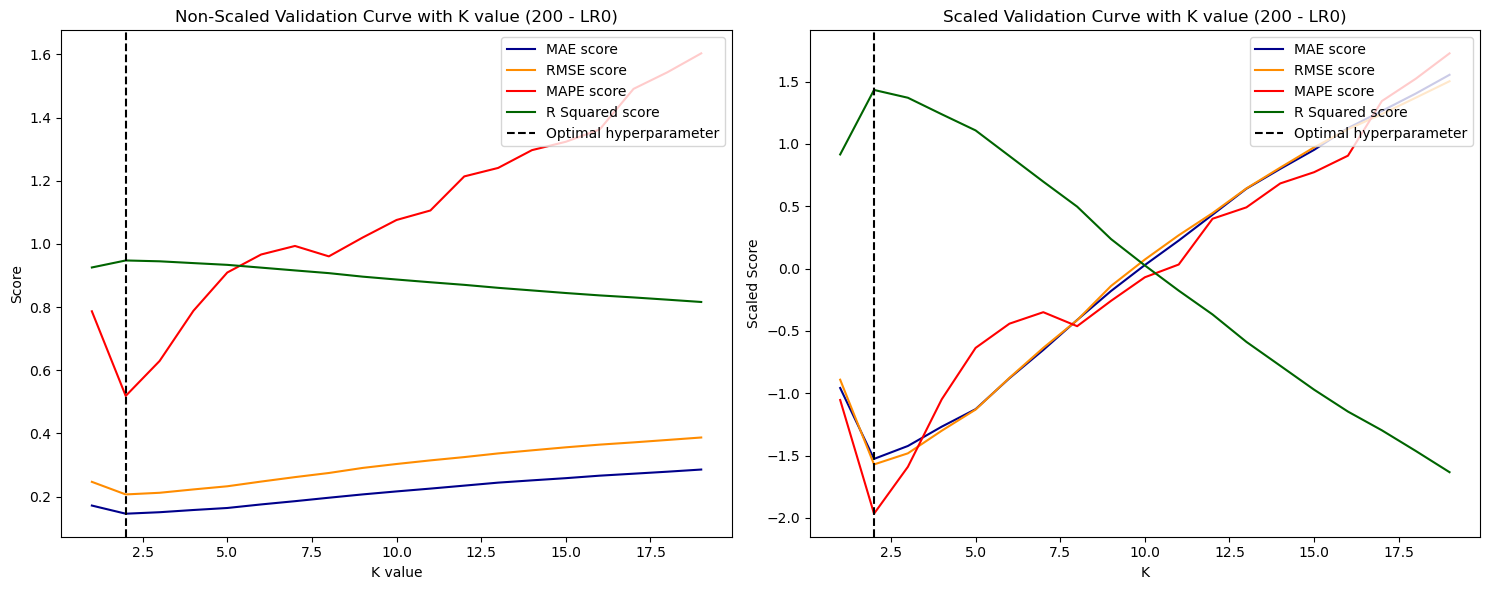

In [8]:
k = 2
df = pd.DataFrame(cv_score_list_200_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (200 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (200 - LR0)")

plt.tight_layout()
plt.show()

# 400 points calibration

In [9]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal400.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal400.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal400.csv')

In [10]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_400_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_400_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.114547,0.101747,0.101277,0.106809,0.108666,0.113094,0.120330,0.126150,0.133387,0.138495,0.145507,0.151930,0.157879,0.164788,0.171408,0.178082,0.185205,0.191260,0.197248
Validation Score RMSE,0.161289,0.143052,0.142218,0.150085,0.152392,0.158513,0.168301,0.175352,0.183506,0.190853,0.201458,0.210792,0.218836,0.228416,0.238619,0.246998,0.256388,0.265128,0.273217
Validation Score MAPE,0.514557,0.462008,0.497375,0.419940,0.427066,0.524361,0.536808,0.533445,0.635527,0.661465,0.702109,0.789228,0.847325,0.875731,0.907220,0.985986,0.981900,0.995928,1.028413
Validation Score R Squared,0.968036,0.974855,0.975148,0.972322,0.971464,0.969127,0.965196,0.962218,0.958623,0.955243,0.950132,0.945403,0.941157,0.935892,0.930037,0.925037,0.919229,0.913629,0.908278


The smallest Validation Score MAE is 0.10127719746184778, found in K = 3.
The smallest Validation Score RMSE is 0.14221793287499054, found in K = 3.
The smallest Validation Score MAPE is 0.4199397190499782, found in K = 4.
The largest Validation Score R Squared is 0.9751476632871042, found in K = 3.
Validation Computation Time: 0.22 seconds


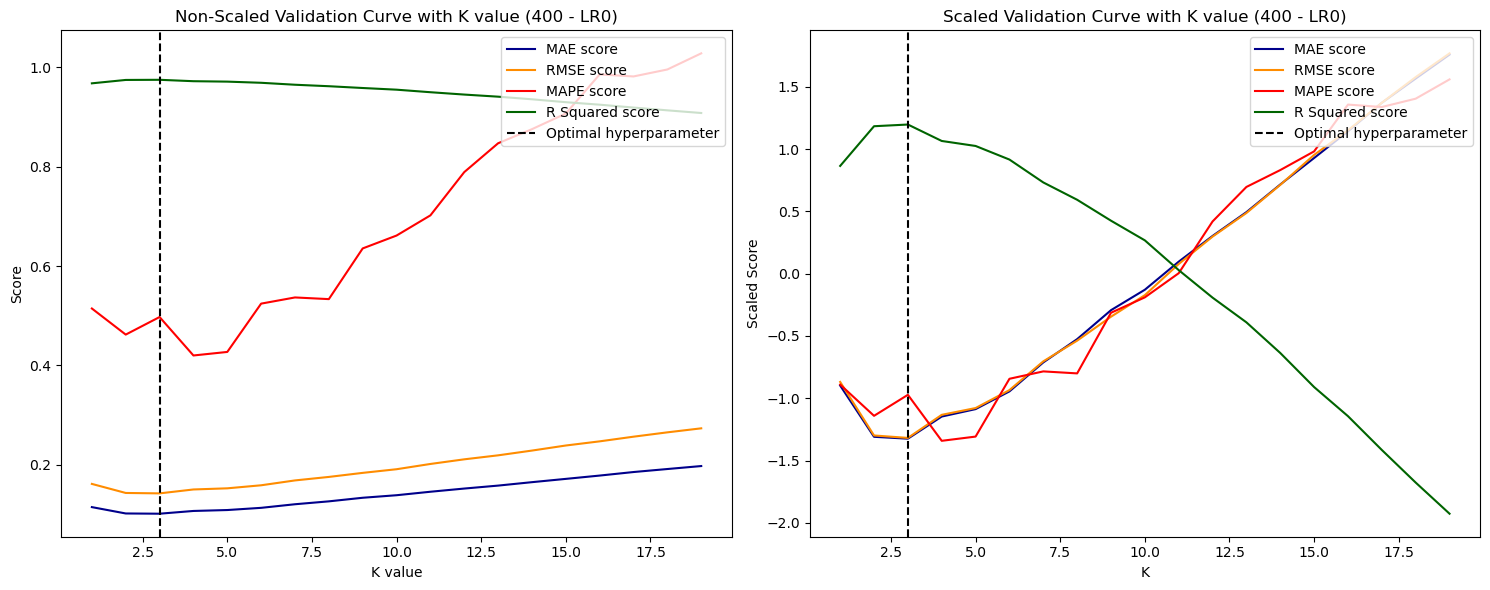

In [12]:
k = 3
df = pd.DataFrame(cv_score_list_400_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (400 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (400 - LR0)")

plt.tight_layout()
plt.show()

# 600 points calibration

In [13]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal600.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal600.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal600.csv')

In [14]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_600_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_600_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.097242,0.085968,0.084543,0.085654,0.087187,0.091812,0.095531,0.101384,0.106491,0.110673,0.115650,0.121140,0.126285,0.131731,0.136187,0.140696,0.146108,0.150168,0.154892
Validation Score RMSE,0.138821,0.125037,0.123021,0.125061,0.126438,0.130573,0.135390,0.140558,0.146926,0.151937,0.159101,0.165967,0.172992,0.180320,0.185659,0.192168,0.199558,0.205387,0.213530
Validation Score MAPE,0.452918,0.417863,0.478337,0.462615,0.481357,0.532401,0.491704,0.536054,0.587192,0.564356,0.612530,0.622490,0.649226,0.715637,0.743482,0.780228,0.841010,0.889384,0.908046
Validation Score R Squared,0.976321,0.980790,0.981404,0.980782,0.980357,0.979051,0.977477,0.975724,0.973475,0.971635,0.968897,0.966154,0.963228,0.960047,0.957646,0.954625,0.951067,0.948167,0.943976


The smallest Validation Score MAE is 0.08454319977342098, found in K = 3.
The smallest Validation Score RMSE is 0.12302141053400481, found in K = 3.
The smallest Validation Score MAPE is 0.4178629491200363, found in K = 2.
The largest Validation Score R Squared is 0.9814039840647408, found in K = 3.
Validation Computation Time: 0.11 seconds


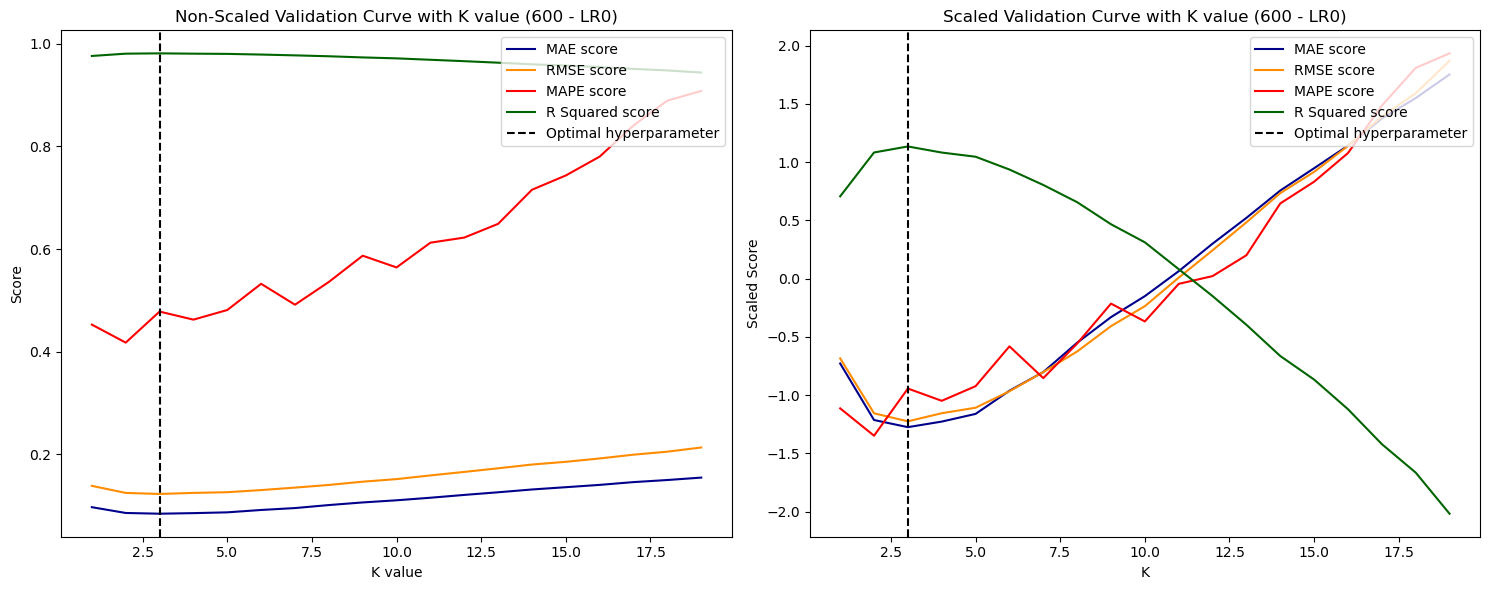

In [15]:
k = 3
df = pd.DataFrame(cv_score_list_600_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (600 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (600 - LR0)")

plt.tight_layout()
plt.show()

# 800 points calibration

In [16]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal800.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal800.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal800.csv')

In [17]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_800_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.086052,0.073652,0.071384,0.072149,0.074435,0.077021,0.079510,0.082241,0.086646,0.089513,0.093600,0.097207,0.101683,0.105072,0.108201,0.112541,0.116156,0.120451,0.123887
Validation Score RMSE,0.122986,0.112118,0.106275,0.108324,0.108684,0.112095,0.114764,0.117974,0.123083,0.126373,0.131520,0.136293,0.141188,0.145308,0.150239,0.155565,0.159976,0.165104,0.169852
Validation Score MAPE,0.369078,0.370798,0.322416,0.376749,0.390503,0.410599,0.393641,0.387701,0.389891,0.430551,0.417223,0.428704,0.469966,0.505957,0.517795,0.513582,0.555199,0.565961,0.593443
Validation Score R Squared,0.981415,0.984554,0.986122,0.985582,0.985486,0.984560,0.983817,0.982899,0.981385,0.980377,0.978746,0.977175,0.975506,0.974056,0.972265,0.970264,0.968554,0.966505,0.964551


The smallest Validation Score MAE is 0.07138412520045669, found in K = 3.
The smallest Validation Score RMSE is 0.10627518316471012, found in K = 3.
The smallest Validation Score MAPE is 0.32241589267589527, found in K = 3.
The largest Validation Score R Squared is 0.9861221487083746, found in K = 3.
Validation Computation Time: 0.12 seconds


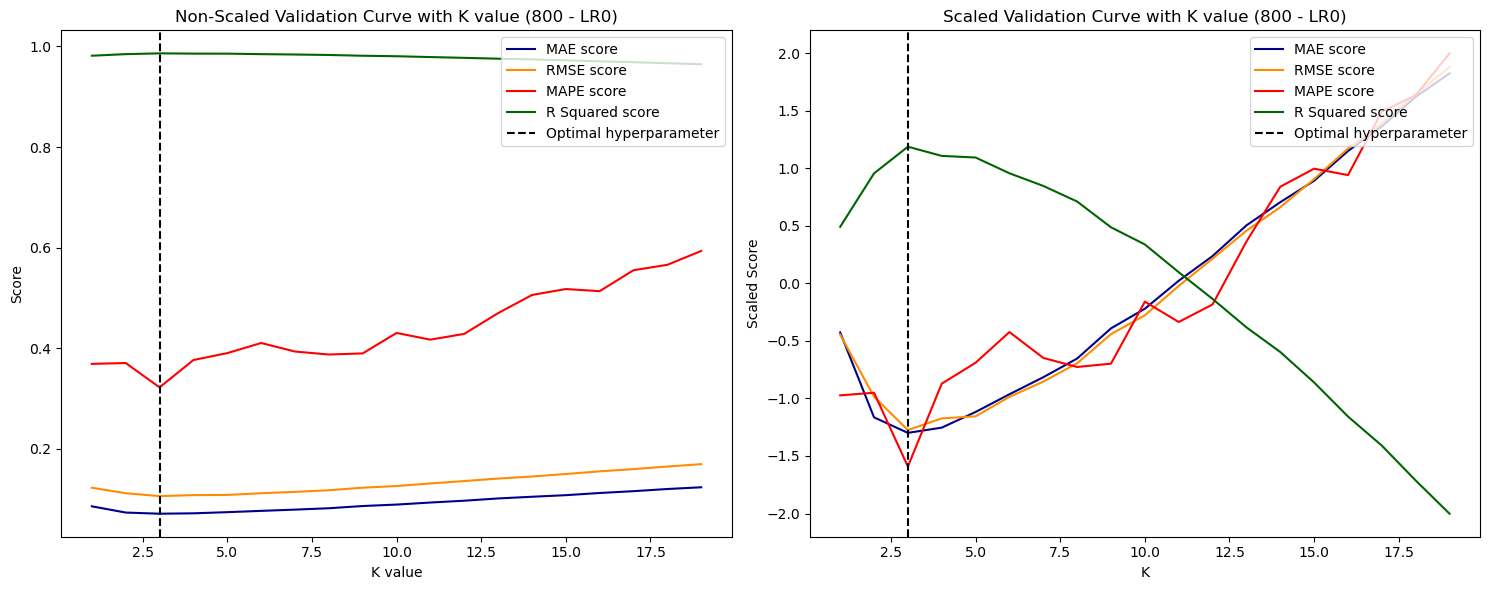

In [18]:
k = 3
df = pd.DataFrame(cv_score_list_800_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (800 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (800 - LR0)")

plt.tight_layout()
plt.show()

# 1000 points calibration

In [19]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal1000.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal1000.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal1000.csv')

In [20]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_1000_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.076765,0.064428,0.061452,0.061831,0.063080,0.064254,0.067417,0.070290,0.073529,0.076065,0.078356,0.081737,0.085201,0.088183,0.091827,0.095430,0.098886,0.102108,0.105063
Validation Score RMSE,0.107107,0.094523,0.090777,0.090885,0.091470,0.092669,0.096282,0.099155,0.102775,0.106032,0.108866,0.113824,0.117236,0.121417,0.126589,0.130471,0.135233,0.140162,0.143879
Validation Score MAPE,0.341765,0.313457,0.271551,0.351275,0.365168,0.338012,0.328244,0.384481,0.389810,0.359467,0.395463,0.394857,0.384512,0.429716,0.428339,0.437807,0.452691,0.453400,0.468233
Validation Score R Squared,0.985904,0.989022,0.989875,0.989851,0.989720,0.989448,0.988609,0.987919,0.987021,0.986186,0.985437,0.984081,0.983112,0.981886,0.980310,0.979084,0.977529,0.975861,0.974564


The smallest Validation Score MAE is 0.06145151630977371, found in K = 3.
The smallest Validation Score RMSE is 0.0907774915616784, found in K = 3.
The smallest Validation Score MAPE is 0.27155058675037796, found in K = 3.
The largest Validation Score R Squared is 0.9898745377050671, found in K = 3.
Validation Computation Time: 0.15 seconds


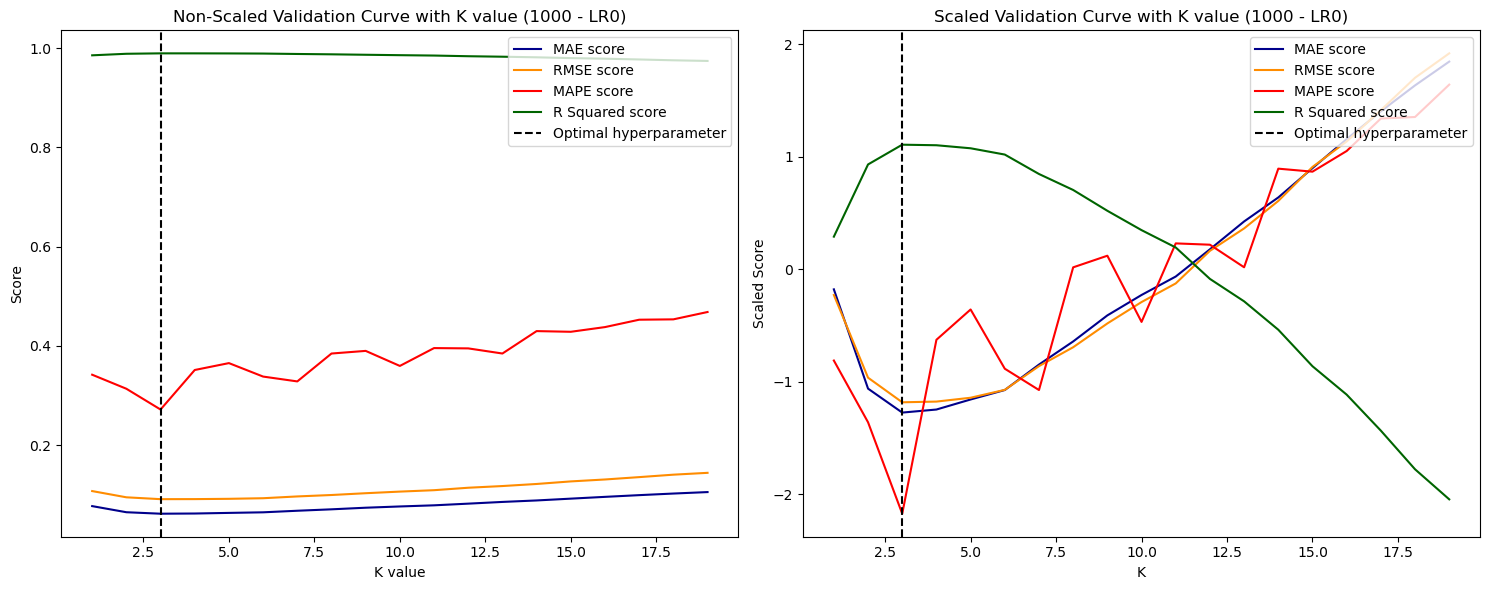

In [21]:
k = 3
df = pd.DataFrame(cv_score_list_1000_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (1000 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (1000 - LR0)")

plt.tight_layout()
plt.show()

# 1500 points calibration

In [22]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal1500.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal1500.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal1500.csv')

In [23]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_1500_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.065796,0.053835,0.051556,0.050377,0.050778,0.051978,0.052945,0.055388,0.056900,0.057993,0.060587,0.062864,0.064605,0.067426,0.068917,0.071466,0.073611,0.075658,0.077869
Validation Score RMSE,0.088601,0.079322,0.077680,0.074754,0.075762,0.077047,0.078997,0.081770,0.083557,0.085511,0.087843,0.089716,0.091546,0.094467,0.096901,0.100237,0.102907,0.105643,0.108636
Validation Score MAPE,0.306254,0.260341,0.234084,0.276172,0.305188,0.324931,0.319678,0.316010,0.291169,0.300275,0.321522,0.344504,0.314280,0.344501,0.344323,0.378923,0.365971,0.364210,0.356178
Validation Score R Squared,0.990354,0.992269,0.992586,0.993134,0.992947,0.992706,0.992332,0.991784,0.991421,0.991015,0.990519,0.990110,0.989702,0.989035,0.988462,0.987654,0.986988,0.986287,0.985499


The smallest Validation Score MAE is 0.050376998606132255, found in K = 4.
The smallest Validation Score RMSE is 0.07475362163037584, found in K = 4.
The smallest Validation Score MAPE is 0.234083639863218, found in K = 3.
The largest Validation Score R Squared is 0.993133696732366, found in K = 4.
Validation Computation Time: 0.14 seconds


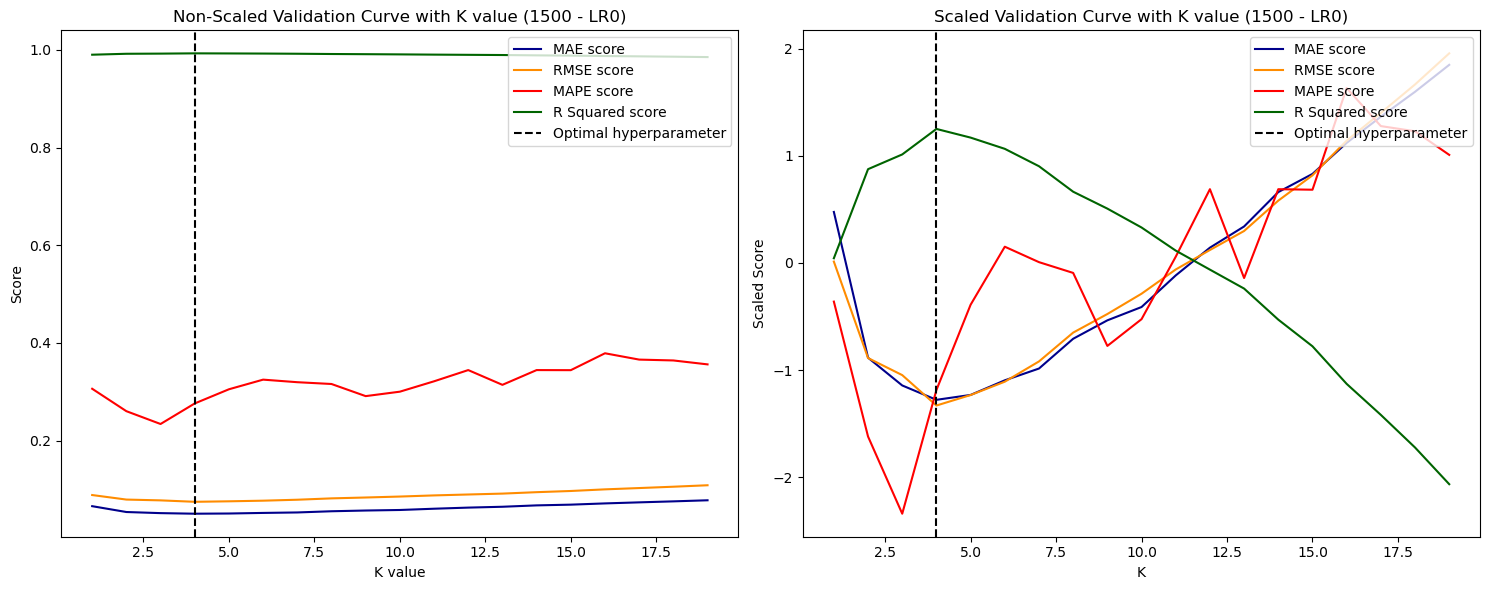

In [24]:
k = 4
df = pd.DataFrame(cv_score_list_1500_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (1500 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (1500 - LR0)")

plt.tight_layout()
plt.show()

# 2000 points calibration

In [25]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal2000.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal2000.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal2000.csv')

In [26]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_2000_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.058357,0.044514,0.042465,0.041823,0.041390,0.041877,0.042640,0.042979,0.045104,0.046388,0.048103,0.049513,0.051268,0.053296,0.054868,0.056743,0.058019,0.059498,0.061195
Validation Score RMSE,0.077243,0.063425,0.060673,0.059839,0.059163,0.060251,0.061350,0.061794,0.064017,0.066438,0.069366,0.071252,0.073341,0.076026,0.078565,0.081027,0.082464,0.084284,0.086870
Validation Score MAPE,0.242127,0.201000,0.192023,0.253581,0.256943,0.245783,0.273646,0.284620,0.271272,0.265817,0.257223,0.274666,0.298737,0.295922,0.297739,0.312870,0.306684,0.307039,0.298874
Validation Score R Squared,0.992669,0.995057,0.995477,0.995600,0.995699,0.995539,0.995375,0.995308,0.994964,0.994576,0.994088,0.993762,0.993391,0.992898,0.992416,0.991933,0.991644,0.991271,0.990728


The smallest Validation Score MAE is 0.04138995643720054, found in K = 5.
The smallest Validation Score RMSE is 0.059163092224205564, found in K = 5.
The smallest Validation Score MAPE is 0.19202263990989737, found in K = 3.
The largest Validation Score R Squared is 0.9956990911873158, found in K = 5.
Validation Computation Time: 0.15 seconds


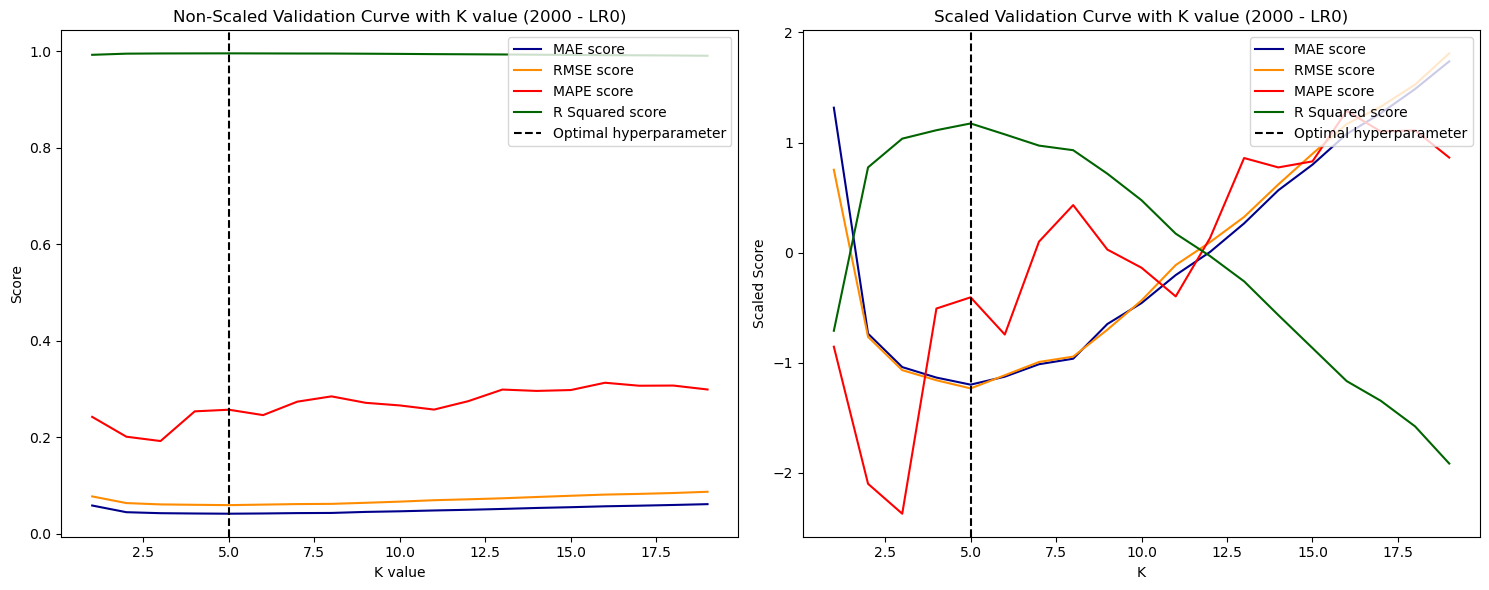

In [27]:
k = 5
df = pd.DataFrame(cv_score_list_2000_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (2000 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (2000 - LR0)")

plt.tight_layout()
plt.show()

## Validation score as calibration set size increases

In [28]:
def calculate_means(data_structures):
    all_means = {}
    for structure_id, data in enumerate(data_structures, 1):
        means = {key: sum(d[key] for d in data.values()) / len(data) for key in data[next(iter(data))]}
        all_means[f"Structure {structure_id}"] = means
    return all_means

# List of data structures
data_structures_k = [cv_score_list_200_k, cv_score_list_400_k, cv_score_list_600_k, cv_score_list_800_k,cv_score_list_1000_k,
                     cv_score_list_1500_k, cv_score_list_2000_k]

# Calculate means
all_means_k = calculate_means(data_structures_k)

In [29]:
new_keys = [200, 400, 600, 800, 1000, 1500, 2000]

# Function to replace keys
def replace_keys(structures, new_keys):
    # Make sure there are enough new keys for the structures
    if len(new_keys) < len(structures):
        raise ValueError("Not enough new keys for the number of structures")

    # New dictionary to store replaced key structures
    replaced_structures = {}

    # Use zip to iterate over both the items in structures and the new_keys simultaneously
    for new_key, (old_key, value) in zip(new_keys, structures.items()):
        replaced_structures[new_key] = value

    return replaced_structures

all_means_k = replace_keys(all_means_k, new_keys)

In [30]:
cal_size = [200, 400, 600, 800, 1000, 1500, 2000]
all_means_k_df = pd.DataFrame(all_means_k).T
all_means_k_df

,Validation Score MAE,Validation Score RMSE,Validation Score MAPE,Validation Score R Squared
200,0.214900,0.298770,1.096236,0.886091
400,0.142516,0.198180,0.701389,0.949528
600,0.114176,0.158866,0.619307,0.967938
800,0.093232,0.131985,0.442619,0.978096
1000,0.079258,0.111019,0.383592,0.984496
1500,0.061608,0.088468,0.319395,0.990253
2000,0.049476,0.070389,0.270346,0.993810


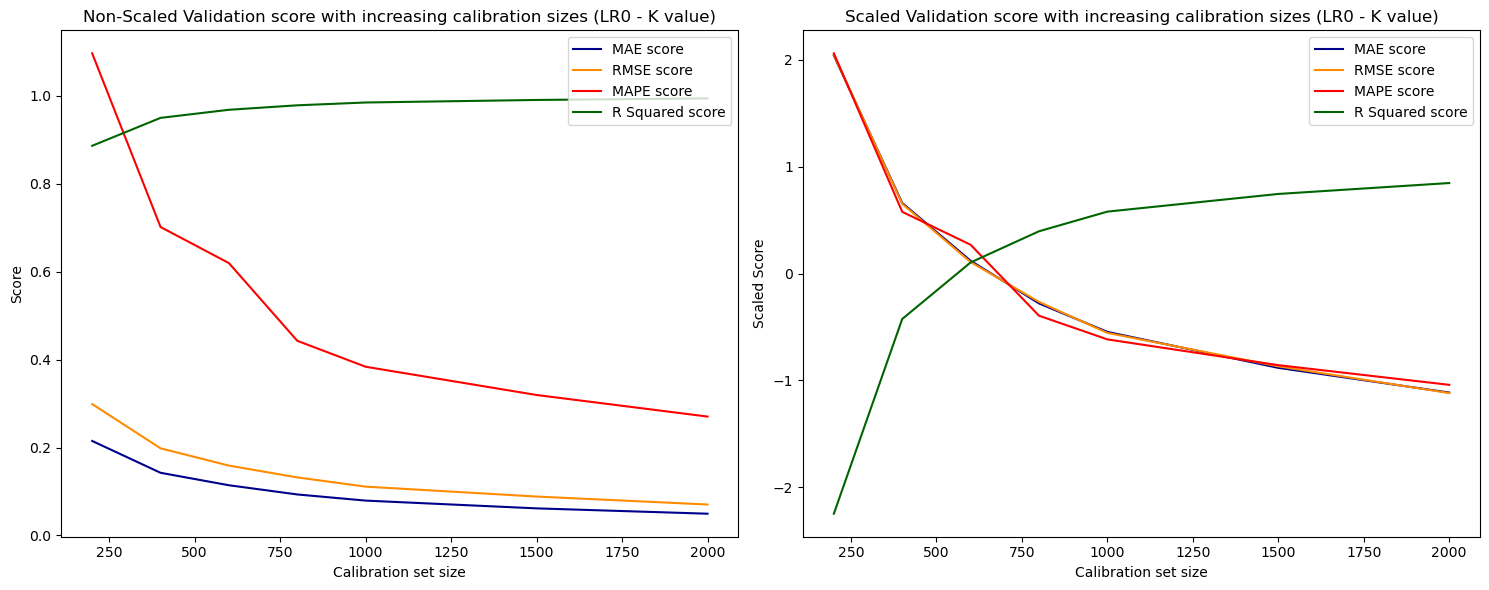

In [31]:
# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_k_df), columns=all_means_k_df.columns, index=all_means_k_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_k_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation score with increasing calibration sizes (LR0 - K value)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation score with increasing calibration sizes (LR0 - K value)")

plt.tight_layout()
plt.show()

## Testing model (Final Performance Metrics)

In [32]:
filenames = ['LR0_input_randomfield_cal200','LR0_input_randomfield_cal400', 'LR0_input_randomfield_cal600',
             'LR0_input_randomfield_cal800', 'LR0_input_randomfield_cal1000', 'LR0_input_randomfield_cal1500', 'LR0_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
combined_df = pd.DataFrame()
for file in filenames:
    cal_df = pd.read_csv(f'Synthetic Data/LR0/cal_{file}.csv')
    combined_df = pd.concat([cal_df, combined_df], ignore_index=True)

combined_df = pd.concat([val_df, combined_df], ignore_index=True)
combined_df = combined_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

combined_df #All caliration points and validation data points

,x,y,z
0,39,4,-2.338943
1,47,42,-0.493586
2,92,88,-1.861865
3,24,43,-2.471080
4,37,92,-0.092991
...,...,...,...
3995,93,12,0.956064
3996,56,25,-0.197968
3997,22,8,-2.663248
3998,38,35,-1.180648


In [35]:
eval_combined_array_coordinates = np.array([list(pair) for pair in zip(combined_df['x'], combined_df['y'])])

start_time = time.time()

nn_model = KNeighborsRegressor(n_neighbors=5)
nn_model.fit(eval_combined_array_coordinates,combined_df['z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_df['x'], test_df['y'])])
z_pred_test = nn_model.predict(eval_combined_array_test)
    
rmse = np.sqrt(mean_squared_error(test_df['z'], z_pred_test))
mae = mean_absolute_error(test_df['z'], z_pred_test)
mape = mean_absolute_percentage_error(test_df['z'], z_pred_test)
r2 = r2_score(test_df['z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.027096433044249694
RMSE: 0.03854183195129807
MAPE: 0.13069114612369812
R Squared: 0.9982116994381262
Testing Computation Time: 0.01 seconds


### Plotting Spatial Interpolation of entire area with Model

In [38]:
filenames = ['cal_LR0_input_randomfield_cal200', 'cal_LR0_input_randomfield_cal400', 'cal_LR0_input_randomfield_cal600', 'cal_LR0_input_randomfield_cal800', 'cal_LR0_input_randomfield_cal1000', 'cal_LR0_input_randomfield_cal1500', 'cal_LR0_input_randomfield_cal2000',
            'val_LR0_input_randomfield_cal2000', 'test_LR0_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
all_df = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(f'Synthetic Data/LR0/{file}.csv')
    all_df = pd.concat([df, all_df], ignore_index=True)

all_df = all_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

all_df #All calbration, validation and test data points

,x,y,z
0,83,56,-0.829437
1,40,74,0.321811
2,90,28,-0.403227
3,51,84,0.128530
4,32,48,-1.498193
...,...,...,...
5995,93,12,0.956064
5996,56,25,-0.197968
5997,22,8,-2.663248
5998,38,35,-1.180648


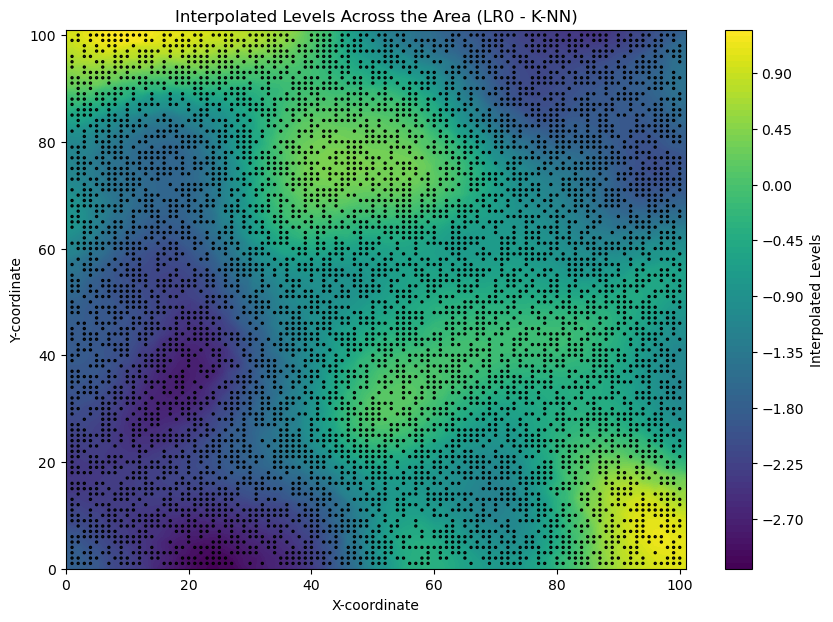

Spatial Interpolation Computation Time: 0.02 seconds


In [42]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'z'
observed_locations = all_df[observed_location_columns].values
observed_values = all_df[observed_values_column].values

# Initialize IDW model
nn_model = KNeighborsRegressor(n_neighbors=5)
nn_model.fit(observed_locations,observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = nn_model.predict(grid_points)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Levels')
plt.scatter(all_df['x'], all_df['y'], c=all_df['z'], cmap='viridis', edgecolor='k', label='Observed', s= 2.0)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
#plt.legend()
plt.title('Interpolated Levels Across the Area (LR0 - K-NN)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")